In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import csv
import string
from collections import Counter
import matplotlib.pyplot as plt
from functools import partial
import io
import pickle as pkl

# SNLI

In [56]:
# load pretrained embedding from files
def load_emb_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data
fname = 'wiki-news-300d-1M.vec'
words_emb_dict = load_emb_vectors(fname)

In [2]:
# read data from tsv
def read_tsv_file(filename):
    premises = []
    hypothesis = []
    labels = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            premises.append(row[0])
            hypothesis.append(row[1])
            labels.append(row[2])
    premises = premises[1:]
    hypothesis = hypothesis[1:]
    labels = labels[1:]
    return premises, hypothesis, labels

In [3]:
train_name = 'hw2_data/snli_train.tsv'
train_premises, train_hypothesis, train_labels = read_tsv_file(train_name)

val_name = 'hw2_data/snli_val.tsv'
val_premises, val_hypothesis, val_labels = read_tsv_file(val_name)

In [5]:
# tokenize data
def tokenize_sentence(sent):
    tokens = sent.strip().split(' ')
    return tokens
# [token.lower() for token in tokens if (token not in punctuations)]

def tokenize_dataset(dataset, train=False):
    dataset_token = []
    all_tokens = []
    for item in dataset:
        item_tokens = tokenize_sentence(item)
        dataset_token.append(item_tokens)
        if train:
            all_tokens.extend(item_tokens)
    return dataset_token, all_tokens

In [6]:
train_premises_tokens, premises_all_tokens = tokenize_dataset(train_premises, train=True)
train_hypothesis_tokens, hypotheis_all_tokens = tokenize_dataset(train_hypothesis, train=True)
train_all_tokens = premises_all_tokens + hypotheis_all_tokens

val_premises_tokens, _ = tokenize_dataset(val_premises, train=False)
val_hypothesis_tokens, _= tokenize_dataset(val_hypothesis, train=False)

min:1, max:41


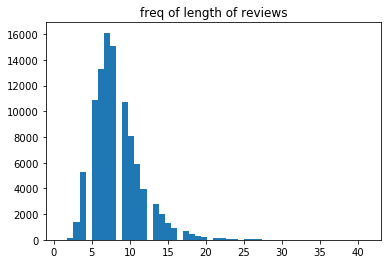

In [8]:
# length statistics 
length_sent = []
for sample in train_hypothesis_tokens:
    length_sent.append(len(sample))
def plot_length_freq(data):
    plt.hist(data, bins=50) #np.arange(min(data), max(data)+1)
    plt.title('freq of length of reviews')
    print('min:{0}, max:{1}'.format(min(data), max(data)))
plot_length_freq(length_sent)

In [9]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    UNK_IDX = 1
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

# load vocab and embeddings
token2id = pkl.load(open("hw2_data/token2id.p", "rb"))
id2token = pkl.load(open("hw2_data/id2token.p", "rb"))
emb_weight = pkl.load(open("hw2_data/embedding_weight.p", "rb"))

In [11]:
train_premises_index = token2index_dataset(train_premises_tokens, token2id)
train_hypothesis_index = token2index_dataset(train_hypothesis_tokens, token2id)

val_premises_index = token2index_dataset(val_premises_tokens, token2id)
val_hypothesis_index = token2index_dataset(val_hypothesis_tokens, token2id)

In [67]:
#Build vovab and embedding matrix according to vocab
def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    PAD_IDX = 0
    UNK_IDX = 1
    token_counter = Counter(all_tokens)
    print('The number of tokens totally: ', len(token_counter))
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token
token2id, id2token = build_vocab(train_all_tokens, max_vocab_size=30000)

def build_emb_weight(words_emb_dict, id2token):
    vocab_size = len(id2token)
    emb_weight = np.zeros([vocab_size, 300])
    for i in range(2,vocab_size):
        emb = words_emb_dict.get(id2token[i], None)
        if emb is not None:
            emb_weight[i] = emb
    return emb_weight

emb_weight = build_emb_weight(words_emb_dict, id2token)

# dump data about vocab and embedding
pkl.dump(token2id, open("hw2_data/token2id.p", "wb"))
pkl.dump(id2token, open("hw2_data/id2token.p", "wb"))
pkl.dump(emb_weight, open("hw2_data/embedding_weight.p", "wb"))

In [12]:
# transform labels
label_dict = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
train_labels_index = [label_dict[label] for label in train_labels]
val_labels_index = [label_dict[label] for label in val_labels]

In [13]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, premises_list, hypothesis_list, labels_list, max_length_pre, max_length_hy):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.premises_list = premises_list
        self.hypothesis_list = hypothesis_list
        self.labels_list = labels_list
        self.max_length_pre = max_length_pre
        self.max_length_hy = max_length_hy
        assert (len(self.premises_list) == len(self.labels_list))
        assert (len(self.hypothesis_list) == len(self.labels_list))

    def __len__(self):
        return len(self.premises_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        premises_idx = self.premises_list[key][:self.max_length_pre]
        hypothesis_idx = self.hypothesis_list[key][:self.max_length_hy]
        label = self.labels_list[key]
        return [premises_idx, hypothesis_idx, label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    premises_list = []
    hypothesis_list = []
    label_list = []
    len_pre_list = []
    len_hy_list = []
    for datum in batch:
        label_list.append(datum[2])
        len_pre = len(datum[0])
        len_hy = len(datum[1])
        len_pre_list.append(len_pre)
        len_hy_list.append(len_hy)
    sort_indices_pre = np.argsort(len_pre_list)[::-1].copy()
    sort_indices_hy = np.argsort(len_hy_list)[::-1].copy()
    args_indices_pre = np.argsort(sort_indices_pre).copy()
    args_indices_hy = np.argsort(sort_indices_hy).copy()
    max_length_pre = max(len_pre_list)
    max_length_hy = max(len_hy_list)
    for idx, datum in enumerate(batch):
    # padding
        padded_pre = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_length_pre-len_pre_list[idx])), 
                                mode="constant", constant_values=0)
        premises_list.append(padded_pre)
        padded_hy = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_length_hy-len_hy_list[idx])), 
                                mode="constant", constant_values=0)
        hypothesis_list.append(padded_hy)
    return [torch.from_numpy(np.array(premises_list)), 
            torch.from_numpy(np.array(hypothesis_list)),
            sorted(len_pre_list, reverse=True),
            sorted(len_hy_list, reverse=True),
            (torch.LongTensor(sort_indices_pre), torch.LongTensor(args_indices_pre)),
            (torch.LongTensor(sort_indices_hy), torch.LongTensor(args_indices_hy)),
            torch.LongTensor(label_list)]

def create_dataset_obj(train,val,train_targets,val_targets,BATCH_SIZE,
                       max_len_pre,max_len_hy,newsgroup_collate_func):
    train_dataset = NewsGroupDataset(train[0], train[1], train_targets, max_len_pre, max_len_hy)
    # premises_list, hypothesis_list, labels_list, max_length_pre, max_length_hy
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val[0], val[1], val_targets, max_len_pre, max_len_hy)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    return train_loader, val_loader

In [50]:
def create_emb_layer(weights_matrix, trainable=False):
    'pretrained embedding layer'
    vocab_size, emb_dim = weights_matrix.size()
    emb_layer = nn.Embedding(vocab_size, emb_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if trainable == False:
        emb_layer.weight.requires_grad = False
    return emb_layer, vocab_size, emb_dim

class model_with_RNN(nn.Module):
    def __init__(self, hidden_size_pre, hidden_size_hy, hidden_size, 
                 drop_rate, num_classes, weights_matrix):

        super(model_with_RNN, self).__init__()

        self.hidden_size_pre, self.hidden_size_hy = hidden_size_pre, hidden_size_hy
        self.embedding, vocab_size, emb_dim = create_emb_layer(weights_matrix, trainable=False)
        
        # module for premise
        self.pre_rnn = nn.GRU(emb_dim, hidden_size_pre, batch_first=True, bidirectional=True)
        
        # module for hypothesis
        self.hy_rnn = self.pre_rnn
        # nn.GRU(emb_dim, hidden_size_hy, batch_first=True, bidirectional=True)
        
        # module for interaction
        self.dropout = nn.Dropout(drop_rate)
        self.linear1 = nn.Linear((hidden_size_pre+hidden_size_hy)*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, pre, hy, pre_len, hy_len, indices_pre, indices_hy):
        #module for premise
        embed = self.embedding(pre)
        embed = torch.index_select(embed, 0, indices_pre[0])
        embed = nn.utils.rnn.pack_padded_sequence(embed, pre_len, batch_first=True)
        output_rnn, hidden_rnn = self.pre_rnn(embed)
        hidden_rnn = torch.index_select(hidden_rnn, 1, indices_pre[1])
        #print(hidden_rnn.size())
        output_pre = torch.cat([hidden_rnn[0,:,:], hidden_rnn[1,:,:]], 1)
        
        
        #module for hypothesis
        embed = self.embedding(hy)
        embed = torch.index_select(embed, 0, indices_hy[0])
        embed = nn.utils.rnn.pack_padded_sequence(embed, hy_len, batch_first=True)
        output_rnn, hidden_rnn = self.hy_rnn(embed)
        hidden_rnn = torch.index_select(hidden_rnn, 1, indices_hy[1])
        output_hy = torch.cat([hidden_rnn[0,:,:], hidden_rnn[1,:,:]], 1)
        #print(output_hy.size())
        
        hidden_cat = torch.cat((output_pre, output_hy), 1)
        #print(hidden_cat.size())
        
        # full connected layers
        hidden_cat = self.dropout(hidden_cat)
        hidden = self.linear1(hidden_cat)
        hidden = F.relu(hidden)
        logits = self.linear2(hidden)
        #print(logits.size())
        return logits
    
def test_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss = []
    model.eval()
    for pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy, labels_batch in loader:
        pre_batch, hy_batch, labels_batch = pre_batch.cuda(), hy_batch.cuda(), labels_batch.cuda()
        indices_pre, indices_hy = (indices_pre[0].cuda(), indices_pre[1].cuda()), (indices_hy[0].cuda(), indices_hy[1].cuda())
        outputs = model(pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy)
        loss.append((criterion(outputs, labels_batch)).item())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels_batch.size(0)
        correct += predicted.eq(labels_batch.cuda().view_as(predicted)).sum().item()
    return np.mean(loss), (100 * correct / total)

def compute_train_acc_batch(pre_batch, hy_batch, pre_len_batch, hy_len_batch, 
                            indices_pre, indices_hy, labels_batch, model):
    outputs = model(pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy)
    outputs = F.softmax(outputs, dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    acc = predicted.eq(labels_batch.view_as(predicted)).sum().item()/predicted.size(0)
    return 100*acc

In [265]:
params = {
    'learning_rate': 0.001,
    'num_epochs': 10,
    'batch_size': 100,
    'best_model_name': 'best_rnn_1.pt',
    
    'hidden_size_pre': 100, 
    'hidden_size_hy': 100,
    'hidden_size': 100,
    'drop_rate': 0.2,
    
    'max_len_pre': 98,
    'max_len_hy': 41,
    
    'train': (train_premises_index,train_hypothesis_index),
    'val': (val_premises_index,val_hypothesis_index),
    'train_targets': train_labels_index,
    'val_targets': val_labels_index
}

In [ ]:
def train_model(params):
    BATCH_SIZE = params['batch_size']
    max_len_pre = params['max_len_pre']
    max_len_hy = params['max_len_hy']
    train = params['train']
    val = params['val']
    train_targets = params['train_targets']
    val_targets = params['val_targets']
    dropout = params['drop_rate']
    drop_rate = params['drop_rate']
    train_loader, val_loader = create_dataset_obj(train,val,train_targets,val_targets,
                                                  BATCH_SIZE,max_len_pre,max_len_hy,
                                                  newsgroup_collate_func)
    # build model
    hidden_size_pre = params['hidden_size_pre']
    hidden_size_hy = params['hidden_size_hy']
    hidden_size = params['hidden_size']
    num_classes = 3
    weights_matrix = torch.from_numpy(emb_weight)
    model = model_with_RNN(hidden_size_pre, hidden_size_hy, hidden_size, 
                           drop_rate, num_classes, weights_matrix)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    trainable_params_num = sum([np.prod(p.size()) for p in model_parameters])
    print('The number of train parameters', trainable_params_num)

    model.cuda()

    #parameter for training
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs'] # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    max_val_acc = 0

    for epoch in range(num_epochs):
        for i, (pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy, labels_batch) in enumerate(train_loader):
            pre_batch, hy_batch, labels_batch = pre_batch.cuda(), hy_batch.cuda(), labels_batch.cuda()
            indices_pre, indices_hy = (indices_pre[0].cuda(), indices_pre[1].cuda()), (indices_hy[0].cuda(), indices_hy[1].cuda())
            model.train()
            optimizer.zero_grad()
            outputs = model(pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0:
                # validate
                train_loss_list.append(loss.item())
                acc_train = compute_train_acc_batch(pre_batch, hy_batch, pre_len_batch, 
                                                    hy_len_batch, indices_pre, indices_hy, 
                                                    labels_batch, model)
                train_acc_list.append(acc_train)
                loss_val, acc_val = test_model(val_loader, model, criterion)
                val_loss_list.append(loss_val)
                val_acc_list.append(acc_val)
#                 if i % 100 == 0:
#                     print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValLoss:{:.6f}, TrainAcc:{}, ValAcc:{}'.format(
#                         epoch+1, num_epochs, i+1, len(train_loader), loss, loss_val, acc_train, acc_val))
        loss_val, acc_val = test_model(val_loader, model, criterion)
        print('Epoch: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, acc_val))
        if epoch > 3 and acc_val > max_val_acc:
            max_val_acc = acc_val
            # save best model
            # model.save_state_dict(params['best_model_name'])
            # model.load_state_dict(torch.load('mytraining.pt'))
    return max_val_acc, trainable_params_num, train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [58]:
result2 = train_model(params)

The number of train parameters 281603
Epoch: [1/10], Validation Acc: 60.5
Epoch: [2/10], Validation Acc: 66.0
Epoch: [3/10], Validation Acc: 66.8
Epoch: [4/10], Validation Acc: 69.6
Epoch: [5/10], Validation Acc: 69.9
Epoch: [6/10], Validation Acc: 71.5
Epoch: [7/10], Validation Acc: 70.7
Epoch: [8/10], Validation Acc: 71.2
Epoch: [9/10], Validation Acc: 72.8
Epoch: [10/10], Validation Acc: 71.9


72.7 72.8 70.7
281603 281603 281603


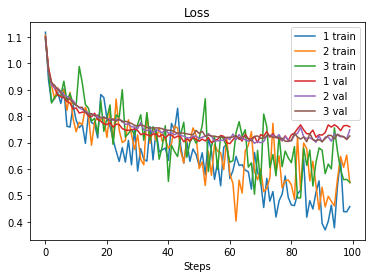

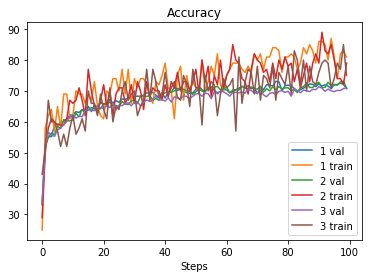

In [61]:
# plot results
max_val_acc1, params_num1, train_loss_list1, train_acc_list1, val_loss_list1, val_acc_list1 = result1
max_val_acc2, params_num2, train_loss_list2, train_acc_list2, val_loss_list2, val_acc_list2 = result2
max_val_acc3, params_num3, train_loss_list3, train_acc_list3, val_loss_list3, val_acc_list3 = result3
# max_val_acc4, params_num4, train_loss_list4, train_acc_list4, val_loss_list4, val_acc_list4 = result4
print(max_val_acc1, max_val_acc2, max_val_acc3)
print(params_num1, params_num2, params_num3)

intevel = 1
plt.title('Loss')
plt.plot(train_loss_list1[::10], label='1 train')
plt.plot(train_loss_list2[::intevel], label='2 train')
plt.plot(train_loss_list3[::intevel], label='3 train')
plt.plot(val_loss_list1[::10], label='1 val')
plt.plot(val_loss_list2[::intevel], label='2 val')
plt.plot(val_loss_list3[::intevel], label='3 val')
# plt.plot(train_loss_list3[::intevel], label='3')
# plt.plot(train_loss_list4[::intevel], label='4')
plt.legend()
plt.xlabel('Steps')
plt.show()

# plt.title('Val Loss')
# plt.plot(val_loss_list1[::intevel], label='1')
# plt.plot(val_loss_list2[::intevel], label='2')
# plt.plot(val_loss_list3[::intevel], label='3')
# plt.plot(val_loss_list4[::intevel], label='4')
# plt.xlabel('Steps')
# plt.show()

plt.title('Accuracy')
plt.plot(val_acc_list1[::10], label='1 val')
plt.plot(train_acc_list1[::10], label='1 train')
plt.plot(val_acc_list2[::intevel], label='2 val')
plt.plot(train_acc_list2[::intevel], label='2 train')
plt.plot(val_acc_list3[::intevel], label='3 val')
plt.plot(train_acc_list3[::intevel], label='3 train')
plt.xlabel('Steps')
plt.legend()
plt.show()

### evaluation

In [71]:
params = {
    'learning_rate': 0.001,
    'num_epochs': 10,
    'batch_size': 100,
    'best_model_name': 'best_rnn_1.pt',
    
    'hidden_size_pre': 100, 
    'hidden_size_hy': 100,
    'hidden_size': 100,
    'drop_rate': 0.2,
    
    'max_len_pre': 98,
    'max_len_hy': 41,
    
    'train': (train_premises_index,train_hypothesis_index),
    'val': (val_premises_index,val_hypothesis_index),
    'train_targets': train_labels_index,
    'val_targets': val_labels_index
}

In [239]:
# data loader
BATCH_SIZE = params['batch_size']
max_len_pre = params['max_len_pre']
max_len_hy = params['max_len_hy']
train = params['train']
val = params['val']
train_targets = params['train_targets']
val_targets = params['val_targets']
drop_rate = params['drop_rate']
train_loader, val_loader = create_dataset_obj(train,val,train_targets,val_targets,
                                              BATCH_SIZE,max_len_pre,max_len_hy,
                                              newsgroup_collate_func)
# build model
hidden_size_pre = params['hidden_size_pre']
hidden_size_hy = params['hidden_size_hy']
hidden_size = params['hidden_size']
num_classes = 3
weights_matrix = torch.from_numpy(emb_weight)
model = model_with_RNN(hidden_size_pre, hidden_size_hy, hidden_size, 
                       drop_rate, num_classes, weights_matrix)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_params_num = sum([np.prod(p.size()) for p in model_parameters])
print('The number of train parameters', trainable_params_num)

model.cuda()

#parameter for training
learning_rate = params['learning_rate']
num_epochs = params['num_epochs'] # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
max_val_acc = 0

for epoch in range(num_epochs):
    for i, (pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy, labels_batch) in enumerate(train_loader):
        pre_batch, hy_batch, labels_batch = pre_batch.cuda(), hy_batch.cuda(), labels_batch.cuda()
        indices_pre, indices_hy = (indices_pre[0].cuda(), indices_pre[1].cuda()), (indices_hy[0].cuda(), indices_hy[1].cuda())
        model.train()
        optimizer.zero_grad()
        outputs = model(pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 100 == 0:
            # validate
            train_loss_list.append(loss.item())
            acc_train = compute_train_acc_batch(pre_batch, hy_batch, pre_len_batch, 
                                                hy_len_batch, indices_pre, indices_hy, 
                                                labels_batch, model)
            train_acc_list.append(acc_train)
            loss_val, acc_val = test_model(val_loader, model, criterion)
            val_loss_list.append(loss_val)
            val_acc_list.append(acc_val)
#                 if i % 100 == 0:
#                     print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValLoss:{:.6f}, TrainAcc:{}, ValAcc:{}'.format(
#                         epoch+1, num_epochs, i+1, len(train_loader), loss, loss_val, acc_train, acc_val))
    loss_val, acc_val = test_model(val_loader, model, criterion)
    print('Epoch: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, acc_val))
    if epoch > 3 and acc_val > max_val_acc:
        max_val_acc = acc_val
        # save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, params['best_model_name'])
        # torch.save(model, params['best_model_name'])
        #model.load_state_dict(torch.load(params['best_model_name']))

The number of train parameters 281603
Epoch: [1/10], Validation Acc: 63.8
Epoch: [2/10], Validation Acc: 64.2
Epoch: [3/10], Validation Acc: 67.0
Epoch: [4/10], Validation Acc: 68.1
Epoch: [5/10], Validation Acc: 69.9
Epoch: [6/10], Validation Acc: 70.5
Epoch: [7/10], Validation Acc: 69.0
Epoch: [8/10], Validation Acc: 70.7
Epoch: [9/10], Validation Acc: 68.5
Epoch: [10/10], Validation Acc: 70.7


In [243]:
# load model
best_model = model_with_RNN(hidden_size_pre, hidden_size_hy, hidden_size, 
                            drop_rate, num_classes, weights_matrix)
checkpoint = torch.load(params['best_model_name'])
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.cuda()
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model_with_RNN(
  (embedding): Embedding(21008, 300)
  (pre_rnn): GRU(300, 100, batch_first=True, bidirectional=True)
  (hy_rnn): GRU(300, 100, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [244]:
best_model.eval()
predict_all = []
for pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy, labels_batch in val_loader:
    pre_batch, hy_batch, labels_batch = pre_batch.cuda(), hy_batch.cuda(), labels_batch.cuda()
    indices_pre, indices_hy = (indices_pre[0].cuda(), indices_pre[1].cuda()), (indices_hy[0].cuda(), indices_hy[1].cuda())
    outputs = best_model(pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy)
    outputs = F.softmax(outputs, dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    predict_all.extend([i[0] for i in predicted.cpu().numpy()])
predict_all = np.array(predict_all)

In [245]:
predict_rw = (predict_all == np.array(val_labels_index))
predict_right_indices = np.where(predict_rw==True)[0]
predict_wrong_indices = np.where(predict_rw==False)[0]
id2label_dict = {0:'neutral', 1:'contradiction', 2:'entailment'}

In [247]:
# correct predictions
i = 18
n = predict_right_indices[i]
print('True label: {}, Predict label: {}'.format(id2label_dict[val_labels_index[n]], id2label_dict[predict_all[n]]))
print('Premise:')
print(val_premises[n])
print('Hypothesis:')
print(val_hypothesis[n])

True label: neutral, Predict label: neutral
Premise:
man grilling fish on barbecue
Hypothesis:
The man likes to eat fish .


In [248]:
# incorrect predictions
i = 7
n = predict_wrong_indices[i]
print('True label: {}, Predict label: {}'.format(id2label_dict[val_labels_index[n]], id2label_dict[predict_all[n]]))
print('Premise:')
print(val_premises[n])
print('Hypothesis:')
print(val_hypothesis[n])

True label: contradiction, Predict label: entailment
Premise:
A lone , 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he kneels on a waiting room couch pointed toward the back while looking at something or someone not in the room .
Hypothesis:
The couch is pointed toward the front .


# MultiNLI

In [249]:
# load data
from collections import defaultdict
def read_tsv_file_mnli(filename):
    genre_data = {} #defaultdict(defaultdict(list))
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        head_flag = True
        for row in reader:
            if head_flag:
                head_flag = False
                continue
            genre = row[-1]
            genre_dict = genre_data.get(genre, defaultdict(list))
            genre_dict['premises'].append(row[0])
            genre_dict['hypothesis'].append(row[1])
            genre_dict['labels'].append(row[2])
            genre_data[genre] = genre_dict
    return genre_data

def token_genre_data(genre_data, label_dict, train=False):
    genre_tokens = {}
    all_tokens = {}
    for key, value in genre_data.items():
        genre_tokens_dict = {}
        genre_tokens_dict['premises'], pre_all_tokens = tokenize_dataset(value['premises'], train=train)
        genre_tokens_dict['hypothesis'], hy_all_tokens = tokenize_dataset(value['hypothesis'], train=train)
        genre_tokens_dict['labels'] = [label_dict[label] for label in value['labels']]
        genre_tokens[key] = genre_tokens_dict
        all_tokens[key] = pre_all_tokens + hy_all_tokens
    return genre_tokens, all_tokens
def transform_indices_genre(genre_tokens, token2id):
    genre_indices = {}
    for key, value in genre_tokens.items():
        genre_indices_dict ={}
        genre_indices_dict['premises'] = token2index_dataset(value['premises'], token2id)
        genre_indices_dict['hypothesis'] = token2index_dataset(value['hypothesis'], token2id)
        genre_indices_dict['labels'] = value['labels']
        genre_indices[key] = genre_indices_dict
    return genre_indices

In [178]:
val_genre_filename = 'hw2_data/mnli_val.tsv'
val_genre = read_tsv_file_mnli(val_genre_filename)
val_genre.keys()
val_tokens_genre,_ = token_genre_data(val_genre, label_dict)

train_genre_filename = 'hw2_data/mnli_train.tsv'
train_genre = read_tsv_file_mnli(train_genre_filename)
genres = list(train_genre.keys())
print(genres)
train_tokens_genre, all_tokens_genre = token_genre_data(train_genre, label_dict)

In [185]:
# transform tokens into indices
val_indices_genre = transform_indices_genre(val_tokens_genre, token2id)
train_indices_genre = transform_indices_genre(train_tokens_genre, token2id)

min:2, max:205


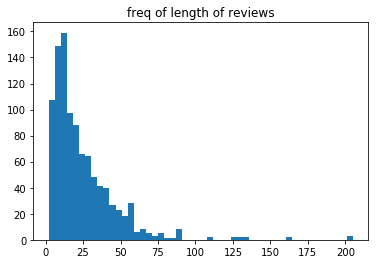

In [275]:
# length statistics 
length_sent = []
for sample in val_tokens_genre['telephone']['premises']:
    length_sent.append(len(sample))
def plot_length_freq(data):
    plt.hist(data, bins=50) #np.arange(min(data), max(data)+1)
    plt.title('freq of length of reviews')
    print('min:{0}, max:{1}'.format(min(data), max(data)))
plot_length_freq(length_sent)

In [272]:
# abnormal data
val_genre['fiction']['premises'][592]

"If you people only knew how fatally easy it is to poison some one by mistake , you would n't joke about it . You would n't joke about poisoning someone if you knew how easy it was to do by mistake . entailment entailment entailment entailment entailment entailment 6977 93955 93955e travel ( ( ( The ( large ( scale production ) ) ) ( of ( entertainment films ) ) ) ( ( ( ( is ( ( a phenomenon ) well ) ) worth ) ( seeing ( several times ) ) ) . ) ) ( ( Watching ( ( the ( impressive production ) ) ( of ( entertainment skills ) ) ) ) ( ( is ( something ( worth ( seeing ( many times ) ) ) ) ) . ) ) ( ROOT ( S ( NP ( NP ( DT The ) ( JJ large ) ( NN scale ) ( NN production ) ) ( PP ( IN of ) ( NP ( NN entertainment ) ( NNS films ) ) ) ) ( VP ( VBZ is ) ( ADVP ( NP ( DT a ) ( NN phenomenon ) ) ( RB well ) ) ( ADJP ( JJ worth ) ) ( S ( VP ( VBG seeing ) ( NP ( JJ several ) ( NNS times ) ) ) ) ) ( . . ) ) ) ( ROOT ( S ( S ( VP ( VBG Watching ) ( NP ( NP ( DT the ) ( JJ impressive ) ( NN producti

In [212]:
# data loader
batch_size_genre = 100
train_genre_loader, val_genre_loader = {}, {}
for key in train_genre.keys():
    train = (train_indices_genre[key]['premises'], train_indices_genre[key]['hypothesis'])
    val = (val_indices_genre[key]['premises'], val_indices_genre[key]['hypothesis'])
    train_genre_loader[key], val_genre_loader[key] = create_dataset_obj(train,val,
                                                                        train_tokens_genre[key]['labels'],
                                                                        val_tokens_genre[key]['labels'],
                                                                        batch_size_genre, 150, 60,
                                                                        newsgroup_collate_func)

In [250]:
# evaluation on genres
for key in train_genre.keys():
    print(key, test_model(val_genre_loader[key], best_model, criterion))

telephone (1.1013628190213984, 48.159203980099505)
fiction (1.0716461002826692, 48.54271356783919)
slate (1.1501114585182883, 44.01197604790419)
government (1.0726692243055864, 46.94881889763779)
travel (1.0971527874469758, 47.86150712830957)


### Fine Tuning

In [264]:
num_epoch_genre = 2

model = model_with_RNN(hidden_size_pre, hidden_size_hy, hidden_size, 
                       drop_rate, num_classes, weights_matrix)
checkpoint = torch.load(params['best_model_name'])
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.cuda()

key = genres[4]
model_path = 'rnn_genre_' +key+'.pt'
print(key, model_path)
train_genre_loader_one = train_genre_loader[key]
val_genre_loader_one = val_genre_loader[key]

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
max_val_acc = 0

for epoch in range(num_epoch_genre):
    for i, (pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy, labels_batch) in enumerate(train_genre_loader_one):
        pre_batch, hy_batch, labels_batch = pre_batch.cuda(), hy_batch.cuda(), labels_batch.cuda()
        indices_pre, indices_hy = (indices_pre[0].cuda(), indices_pre[1].cuda()), (indices_hy[0].cuda(), indices_hy[1].cuda())
        model.train()
        optimizer.zero_grad()
        outputs = model(pre_batch, hy_batch, pre_len_batch, hy_len_batch, indices_pre, indices_hy)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 10 == 0:
            # validate
            train_loss_list.append(loss.item())
            acc_train = compute_train_acc_batch(pre_batch, hy_batch, pre_len_batch, 
                                                hy_len_batch, indices_pre, indices_hy, 
                                                labels_batch, model)
            train_acc_list.append(acc_train)
            loss_val, acc_val = test_model(val_genre_loader_one, model, criterion)
            val_loss_list.append(loss_val)
            val_acc_list.append(acc_val)
            if i % 10 == 0:
                print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValLoss:{:.6f}, TrainAcc:{}, ValAcc:{}'.format(
                    epoch+1, num_epochs, i+1, len(train_genre_loader_one), loss, loss_val, acc_train, acc_val))
    for key in genres:
        loss_val, acc_val = test_model(val_genre_loader[key], model, criterion)
        print('Epoch:{}/{}, Genre:{}, Validation Acc: {}'.format(epoch+1, num_epochs, key, acc_val))
    if acc_val > max_val_acc:
        max_val_acc = acc_val
        # save best model
        # torch.save(model.state_dict(), model_path)

travel rnn_genre_travel.pt
1/10, Step:1/40, TrainLoss:0.932377, ValLoss:1.083102, TrainAcc:64.0, ValAcc:49.08350305498982
1/10, Step:11/40, TrainLoss:0.990298, ValLoss:0.992581, TrainAcc:50.0, ValAcc:50.10183299389002
1/10, Step:21/40, TrainLoss:0.991713, ValLoss:0.985602, TrainAcc:49.0, ValAcc:52.85132382892057
1/10, Step:31/40, TrainLoss:0.958455, ValLoss:0.980004, TrainAcc:57.99999999999999, ValAcc:52.03665987780041
Epoch:1/10, Genre:telephone, Validation Acc: 46.766169154228855
Epoch:1/10, Genre:fiction, Validation Acc: 49.14572864321608
Epoch:1/10, Genre:slate, Validation Acc: 45.50898203592814
Epoch:1/10, Genre:government, Validation Acc: 53.44488188976378
Epoch:1/10, Genre:travel, Validation Acc: 54.073319755600814
2/10, Step:1/40, TrainLoss:1.001778, ValLoss:0.973615, TrainAcc:51.0, ValAcc:54.175152749490834
2/10, Step:11/40, TrainLoss:0.965339, ValLoss:0.973031, TrainAcc:51.0, ValAcc:53.258655804480654
2/10, Step:21/40, TrainLoss:0.960720, ValLoss:0.962740, TrainAcc:59.0, ValA